#Deep Neural Networks

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Evaluation index
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# Download the dataset
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Check the data
print(X.shape) # (60000, 28, 28)
print(X.shape) # (10000, 28, 28)
print(X[0].dtype) # uint8

(60000, 28, 28)
(60000, 28, 28)
uint8


In [4]:
# Smoothing
X_flat = X.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)
print(X_flat.shape)
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


In [6]:
# Type conversion, normalization
X_flat = X_flat.astype(float) # Changed np.float to float
X_test_flat = X_test_flat.astype(float) # Changed np.float to float
X_flat /= 255
X_test_flat /= 255
print(X_flat.max()) # 1.0
print(X_flat.min()) # 0.0

1.0
0.0


In [8]:
# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y.shape) # (60000,)
print(y_one_hot.shape) # (60000, 10)
print(y_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
# Split into training data and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [10]:
# Scratch Deep Neural Network (for now, 3 layer NN)
class ScratchDeepNeuralNetworkClassifier():
    """
    N Layer Neural Network Classifier
    Parameters
    ----------
    self.sigma : Standard deviation of Gaussian distribution
    self.lr : learning rate
    self.n_nodes1 : Number of nodes in the first layer
    self.n_nodes2 : Number of nodes in the second layer
    self.n_output : Number of nodes in the output layer

    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, n_features, n_nodes1, n_nodes2, n_output,
                 sigma, n_epoch, n_batch, lr, verbose = False):
        # Parameters
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.lr = lr
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)

    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))

    def fit(self, X, y, X_val=False, y_val=False):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data
        y : ndarray of the following form, shape (n_samples, )
            Correct answer value of training data
        X_val : ndarray of the following form, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray of the following form, shape (n_samples, )
            Correct value of validation data
        """

        optimizer1 = AdaGrad(self.lr)
        optimizer2 = AdaGrad(self.lr)
        optimizer3 = AdaGrad(self.lr)

        initializer1 = XavierInitializer()
        initializer2 = XavierInitializer()
        initializer3 = SimpleInitializer(self.sigma)

        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1, Tanh())
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2, Tanh())
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3, Softmax())

        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:

                # Forward propagation
                self.Z1 = self.FC1.forward(mini_X_train)
                self.Z2 = self.FC2.forward(self.Z1)
                self.Z3 = self.FC3.forward(self.Z2)

                # Back propagation
                self.dA3 = (self.Z3 - mini_y_train)/self.n_batch
                self.dZ2 = self.FC3.backward(self.dA3)
                self.dZ1 = self.FC2.backward(self.dZ2)
                self.dZ0 = self.FC1.backward(self.dZ1)

                # Loss function
                self.loss += self.loss_function(self.Z3,mini_y_train)

            self.log_loss[epoch] = self.loss/len(get_mini_batch)

    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Sample

        Returns
        -------
            ndarray of the following form, shape (n_samples, 1)
            Estimation results
        """
        pred_Z1 = self.FC1.forward(X)
        pred_Z2 = self.FC2.forward(pred_Z1)
        return np.argmax(self.FC3.forward(pred_Z2),axis=1)

In [28]:
# Mini-batch processing class
class GetMiniBatch:
    """
    Iterator to get the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the follwowing form, shape (n_samples, 1)
      correct value
    batch_size : int
      Batch size
    seed : int
      Seeding random numbers in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]

        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【Problem 1】Coupling layers
Please classify all binding layers.
  
The following is a model. Initialize the weights and biases in the constructor, and then prepare the forward and backward methods. By keeping the weights W, bias B, and the input X for forwarding as instance variables, there is no need for complicated input and output.
  
Note that instances can also be passed as arguments. Therefore, if an instance initializer of the initialization method is received in the constructor, it will be initialized. The initialization method can be changed by changing the instance to be passed.  
  
You can also pass your own instance self as an argument. You can also pass your own instance self as an argument, and use this to update the layer weights as in self.optimizer.update(self). There are multiple values needed for the update, but they can all be instance variables that all coupled layers have.

The initialization method and the class of optimization methods are described below.

In [29]:
class FC:
    """
    All coupling layers from number of nodes n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in subsequent layers
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):

        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # Initialize
         # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)

    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B

        return self.activation.forward(self.A)

    def backward(self, dZ):
        """
        backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)

        # Update
        self = self.optimizer.update(self)

        return dZ

### 【Problem 2】Initialization method
Classify the code to do the initialization.

As mentioned above, make it possible to pass an instance of the initialization method to the constructor of all binding layers. Please add the necessary code to the following template. The value of the standard deviation (sigma) should be received in the constructor, so that we don't have to pass this value (sigma) in the class of the all-binding layer.

The initialization method we have been working with so far will be called the SimpleInitializer class.

In [30]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

### 【Problem 3】Optimization methods
Classify the optimization method.

The optimization method is also passed as an instance to all coupling layers as in the initialization method. It should be able to be updated like self.optimizer.update(self) when it is backward. Please add the necessary code to the following template.

The optimization methods we have covered so far are created as SGD class (Stochastic Gradient Descent).

In [31]:
class SGD:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB

        return layer

### 【Problem 4】Activation Function
Classify the activation function.

The backpropagation of the softmax function should be implemented to include the calculation of the cross-entropy error to simplify the calculation.

In [32]:
class Tanh():
    """
    Activation function : Hyperbolic tangent function
    """
    def __init__(self):
        pass

    def forward(self,A):
        self.A = A
        self.Z = np.tanh(self.A)
        return self.Z

    def backward(self,dZ):
        return dZ*(1-self.Z**2)

In [33]:
class Sigmoid():
    """
    Activation function : Sigmoid function
    """
    def __init__(self):
        pass

    def forward(self,A):
        self.A = A
        self.Z = 1/(1+np.exp(-self.A))

        return self.Z

    def backward(self,dZ):
        return dZ*(1-self.Z)*self.Z

In [34]:
class Softmax():
    """
    Activation Function : Softmax Function
    """
    def __init__(self):
        pass

    def forward(self,A):

        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)

    def backward(self,dZ):
        return dZ

### 【Problem 5】Creating the ReLU class
Implement the (current) commonly used activation function, ReLU (Rectified Linear Unit), as a ReLU class.

ReLU is the following formula.  
$f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}$

In [35]:
class ReLU():
    """
    Activation function : ReLU function
    """
    def __init__(self):
        pass

    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)

    def backward(self,dZ):

        return np.where(self.A>0,dZ,0)

In [36]:
a = np.array([-1,0,1,9,-1])
b = np.array([1,0,-1,9,-1])

print(np.where(a<0,0,b))

[ 0  0 -1  9  0]


### 【Problem 6】Initial value of weight
So far, we have simply used a Gaussian distribution for the initial values of weights and bias, and treated the standard deviation as a hyperparameter. However, it is known what values should be used. For sigmoid and hyperbolic tangent functions, Xavier's initial value (or Glorot's initial value) is used, and for ReLU, He's initial value is used.

Create the XavierInitializer class and the HeInitializer class.

In [37]:
class XavierInitializer():
    """
    Initializing weights with Xavier
    """
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)/np.sqrt(n_nodes1)

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

In [38]:
class HeInitializer():
    """
    Initialization of weights by He
    """
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

### 【Problem 7】Optimization Method
The most common method is to change the learning rate during the learning process.  
Create a class for AdaGrad, which is the basic method.

In [39]:
class AdaGrad:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0

    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB

        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)

        return layer

### 【Problem 8】Completion of the class
Complete the SearchDeepNeuralNetworkClassifier class, which can be trained and estimated in any configuration.

In [40]:
class AdaGrad:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0

    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        # Fix: Accumulate squared gradients for bias as well
        self.hB += layer.dB*layer.dB

        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)

        return layer

In [41]:
clf = ScratchDeepNeuralNetworkClassifier(n_epoch=5, n_features=784,
                                         n_nodes1=400, n_nodes2=200, n_output=10,
                                         sigma=0.01, n_batch=100,
                                         lr = 0.01, verbose = False)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_valid)

In [43]:
# Import the accuracy_score function
from sklearn.metrics import accuracy_score

print(y_pred)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

[3 9 5 ... 9 4 1]
accuracy:0.966


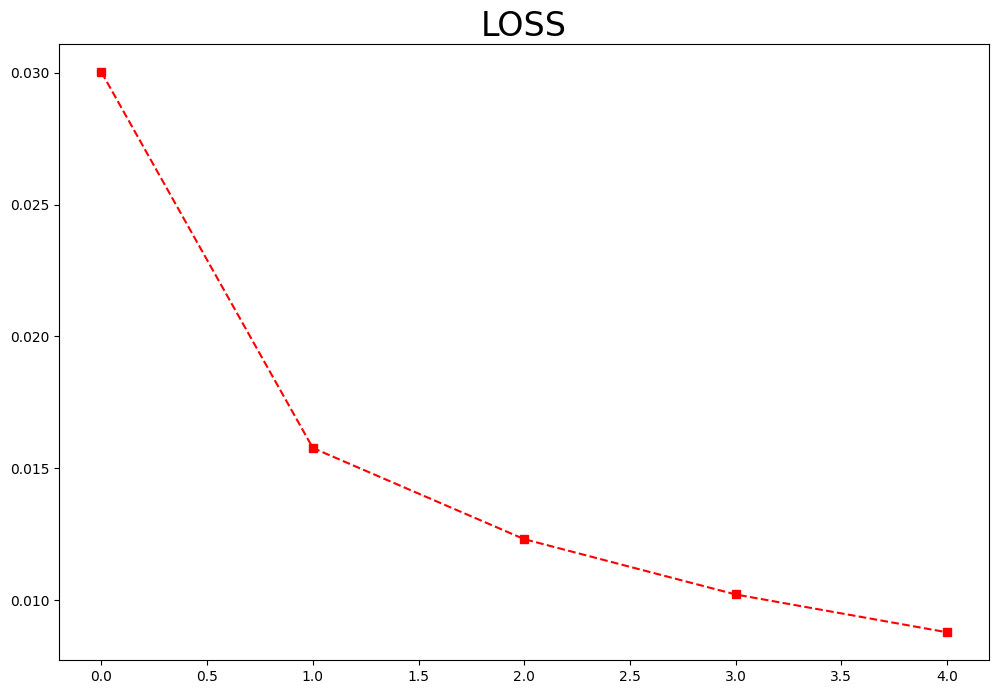

In [44]:
# Visualize the loss function for each epoch
fig = plt.subplots(figsize=(12,8))
plt.rcParams["font.size"] = 20

plt.title('LOSS')
plt.plot(clf.log_loss,'rs--');

### 【Problem 9】Learning and Estimation
Create several networks with different number of layers and activation functions.
Then, train and estimate the MNIST data and calculate the Accuracy.

In [46]:
# Scratch Deep Neural Networks (if you can do it in any layer)
class ScratchDNNClassifier():
    """
    N Layer Neural Network Classifier

    Parameters
    ----------
    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, NN, n_epoch, n_batch, verbose = False):
        # Parameters
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        self.NN = NN

    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))

    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)

    def fit(self, X, y, X_val=False, y_val=False):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data
        y : ndarray of the following form, shape (n_samples, )
            Correct answer value of training data
        X_val : ndarray of the following form, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray of the following form, shape (n_samples, )
            Correct value of validation data
        """
        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:

                # Forward propagation
                forward_data = mini_X_train
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                # Predicted value
                Z = forward_data

                # Back propagation
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)

                # Loss function
                self.loss += self.loss_function(Z,mini_y_train)

            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))

    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Sample

        Returns
        -------
            ndarray of the following form, shape (n_samples, 1)
            Estimation results
        """
        pred_data = X

        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)

        return np.argmax(pred_data,axis=1)

#### Verification 1
* 3 layers (784 → 400 → 200 → 10)
* Activation function for layer 1: ReLU function
* Activation function for layer 2: ReLU function
* Activation function for 3 layers: Softmax function
* Optimization method: AdaGrad

In [48]:
NN2 = {0:FC(784, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
       1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }

In [50]:
clf2 = ScratchDNNClassifier(NN=NN2,n_epoch=30,n_batch=20,verbose = False)

clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_valid)

In [51]:
print(y_pred2)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred2)
print('accuracy:{:.3f}'.format(accuracy))

[3 9 5 ... 9 4 1]
accuracy:0.980


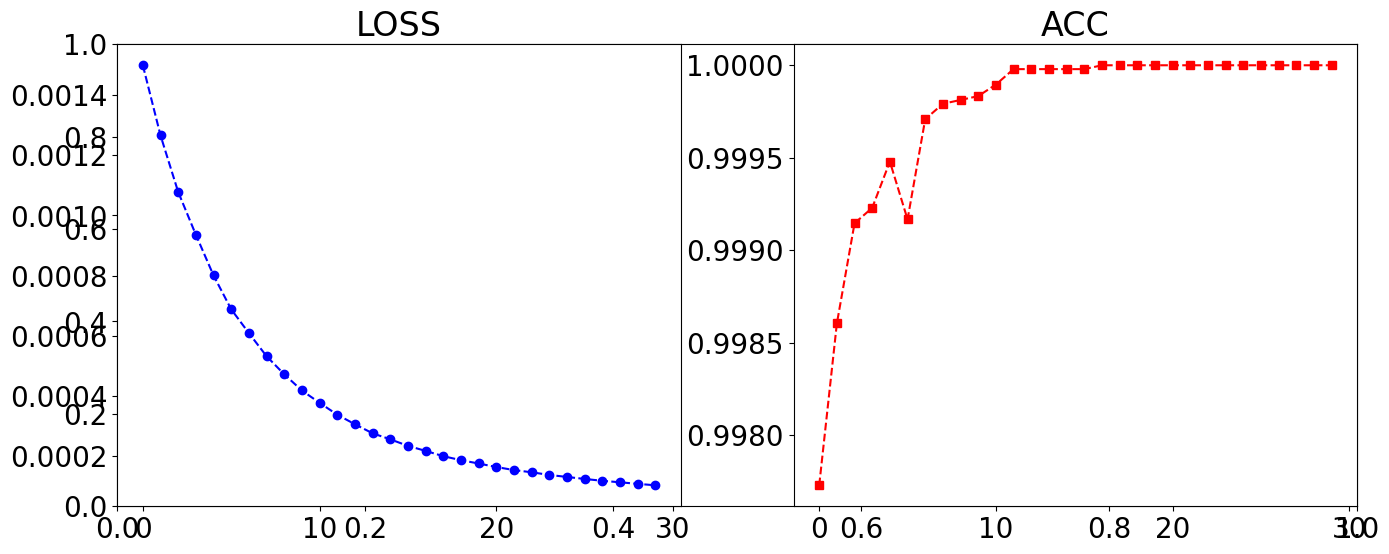

In [52]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf2.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf2.log_acc,'rs--');

#### Search 2
* 4 layers (784,400,600,300,10)
* 1 level: ReLU
* 2 layers: ReLU
* 3 layers: ReLU
* 4 layers: Softmax
* Optimization method: Adagrad

In [53]:
NN3 = {0:FC(784, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
       1:FC(400, 600, HeInitializer(), AdaGrad(0.01), ReLU()),
       2:FC(600, 300, HeInitializer(), AdaGrad(0.01), ReLU()),
       3:FC(300, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }

In [54]:
clf3 = ScratchDNNClassifier(NN=NN3,n_epoch=30,n_batch=20,verbose = False)

clf3.fit(X_train,y_train)
y_pred3 = clf3.predict(X_valid)

In [55]:
print(y_pred3)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred3)
print('accuracy:{:.3f}'.format(accuracy))

[3 9 5 ... 9 4 1]
accuracy:0.980


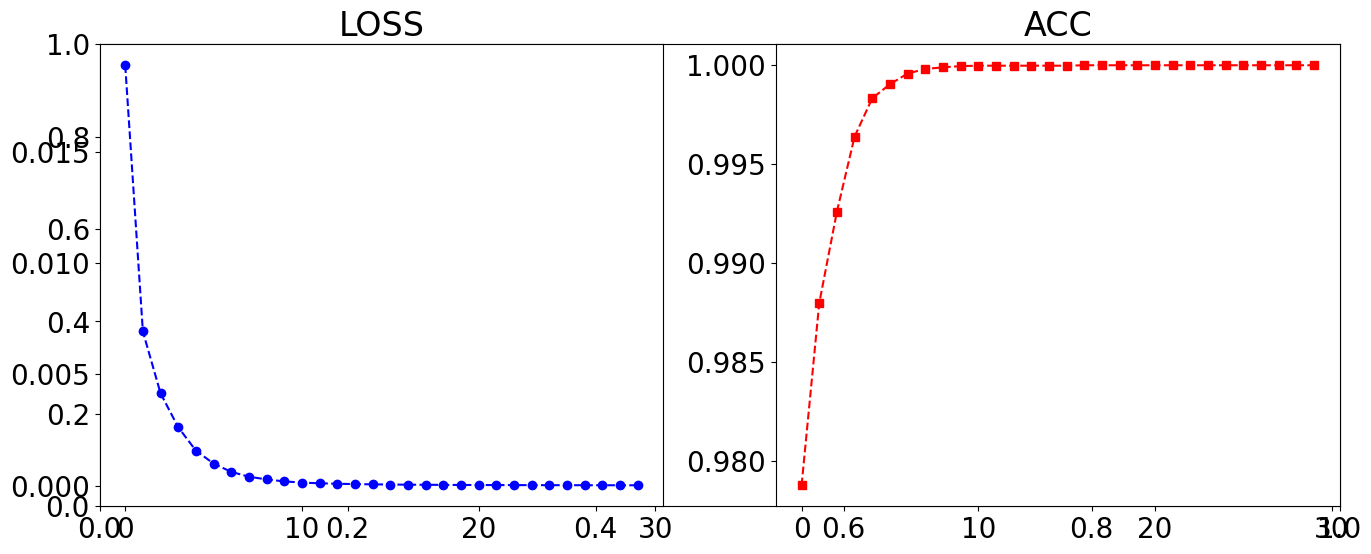

In [56]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf3.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf3.log_acc,'rs--');

#### Search3
* 5 layers(784,400,300,200,100,10)
* 1 layer：Tanh
* 2 layers: Sigomoid
* Layer 3: ReLU
* 4-layer item: ReLU
* Level 5: Softmax
* Optimization method: Adagrad

In [57]:
NN4 = {0:FC(784, 400, XavierInitializer(), AdaGrad(0.01), Tanh()),
       1:FC(400, 300, XavierInitializer(), AdaGrad(0.01), Sigmoid()),
       2:FC(300, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       3:FC(200, 100, HeInitializer(), AdaGrad(0.01), ReLU()),
       4:FC(100, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }

In [58]:
clf4 = ScratchDNNClassifier(NN=NN4,n_epoch=30,n_batch=20,verbose = False)

clf4.fit(X_train,y_train)
y_pred4 = clf4.predict(X_valid)

In [59]:
print(y_pred4)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred4)
print('accuracy:{:.3f}'.format(accuracy))

[3 9 5 ... 9 4 1]
accuracy:0.978


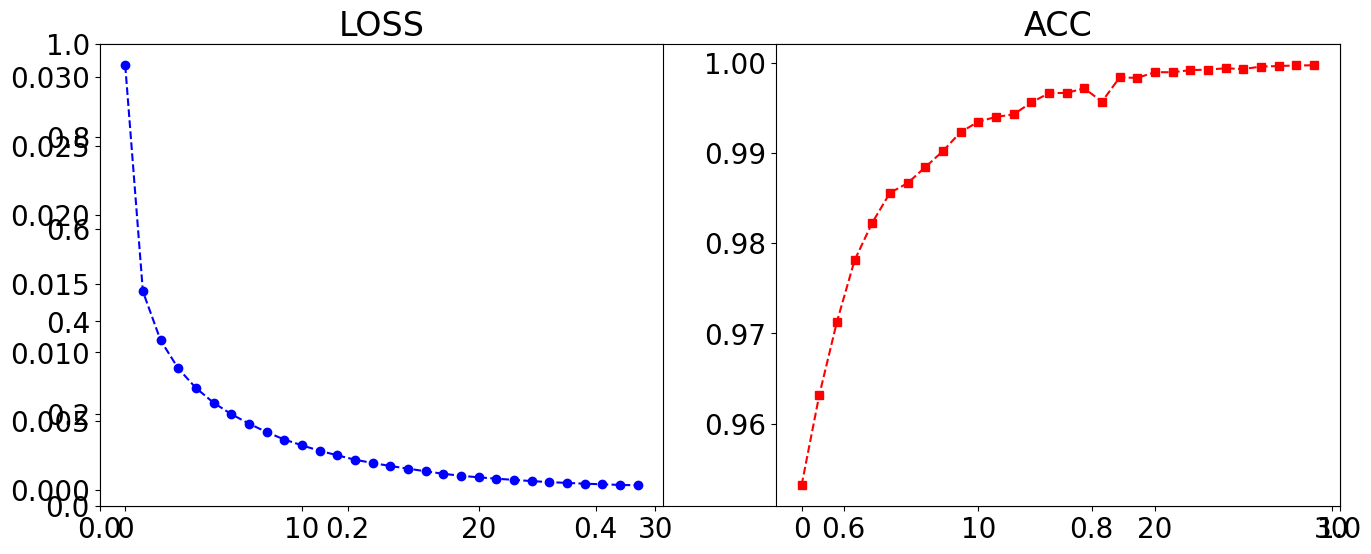

In [60]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf4.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf4.log_acc,'rs--');

### Verification 4


In [61]:
NN5 = {0:FC(784, 400, XavierInitializer(), AdaGrad(0.01), Tanh()),
       1:FC(400, 300, HeInitializer(), AdaGrad(0.01), ReLU()),
       2:FC(300, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       3:FC(200, 100, HeInitializer(), AdaGrad(0.01), ReLU()),
       4:FC(100, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }

In [62]:
clf5 = ScratchDNNClassifier(NN=NN5,n_epoch=30,n_batch=20,verbose = False)

clf5.fit(X_train,y_train)
y_pred5 = clf5.predict(X_valid)

In [63]:
print(y_pred5)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred5)
print('accuracy:{:.3f}'.format(accuracy))

[3 9 5 ... 9 4 1]
accuracy:0.980


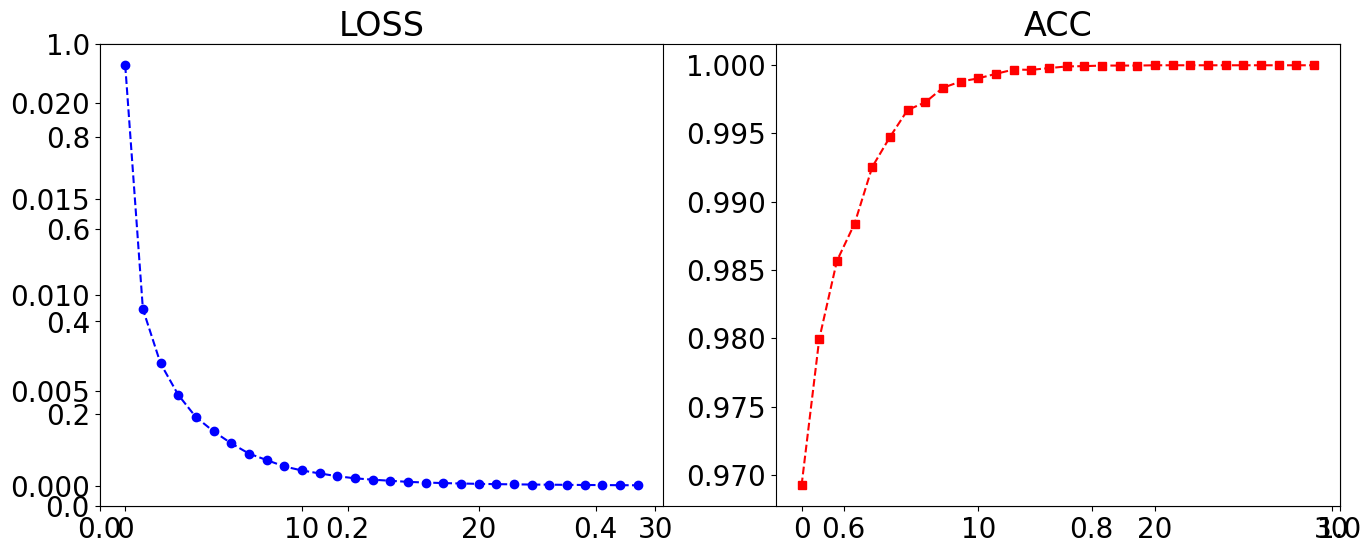

In [64]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf5.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf5.log_acc,'rs--');

* It seems that a deeper layer is not always better.

### Verification (copy of instance)

In [68]:
# Is it enough to instantiate one Adagrad?？
class TestScratchDeepNeuralNetworkClassifier():
    """
    N Layer Neural Network Classifier
    Parameters
    ----------
    self.sigma : Standard deviation of Gaussian distribution
    self.lr : learning rate
    self.n_nodes1 : Number of nodes in the first layer
    self.n_nodes2 : Number of nodes in the second layer
    self.n_output : Number of nodes in the output layer

    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, n_features, n_nodes1, n_nodes2, n_output,
                 sigma, n_epoch, n_batch, lr, verbose = False):
        # Parameters
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.lr = lr
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)

    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))

    def fit(self, X, y, X_val=False, y_val=False):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data
        y : ndarray of the following form, shape (n_samples, )
            Correct answer value of training data
        X_val : ndarray of the following form, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray of the following form, shape (n_samples, )
            Correct value of validation data
        """

        # Create separate optimizer instances for each layer
        optimizer1 = AdaGrad(self.lr)
        optimizer2 = AdaGrad(self.lr)
        optimizer3 = AdaGrad(self.lr)

        initializer1 = XavierInitializer()
        initializer2 = XavierInitializer()
        initializer3 = SimpleInitializer(self.sigma)

        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1, Tanh())
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2, Tanh())
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3, Softmax())

        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:

                # Forward propagation
                self.Z1 = self.FC1.forward(mini_X_train)
                self.Z2 = self.FC2.forward(self.Z1)
                self.Z3 = self.FC3.forward(self.Z2)

                # Back propagation
                # It seems the loss gradient calculation here should be divided by n_batch as in the original ScratchDeepNeuralNetworkClassifier
                # Corrected the loss gradient calculation
                self.dA3 = (self.Z3 - mini_y_train)/self.n_batch
                self.dZ2 = self.FC3.backward(self.dA3)
                self.dZ1 = self.FC2.backward(self.dZ2)
                self.dZ0 = self.FC1.backward(self.dZ1)

                # Loss function
                self.loss += self.loss_function(self.Z3,mini_y_train)

            # The loss is summed over batches, so divide by the number of batches to get the average loss
            self.log_loss[epoch] = self.loss/len(get_mini_batch)


    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Sample

        Returns
        -------
            ndarray of the following form, shape (n_samples, 1)
            Estimation results
        """
        pred_Z1 = self.FC1.forward(X)
        pred_Z2 = self.FC2.forward(pred_Z1)
        return np.argmax(self.FC3.forward(pred_Z2),axis=1)

In [69]:
tst = TestScratchDeepNeuralNetworkClassifier(n_epoch=2, n_features=784,
                                             n_nodes1=400, n_nodes2=200,
                                             n_output=10, sigma=0.01, n_batch=100,
                                             lr = 0.01, verbose = False)

tst.fit(X_train,y_train)
y_pred = tst.predict(X_valid)

* We verified that the instance variable of the Optimizer is not computable due to multiple instances.